# TETTRIs Task 3.2

In [4]:
import requests
import numpy as np
import pandas as pd
#import itertools # not used?
#import openalexapi # not used yet
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#import nltk
#from nltk.stem import LancasterStemmer
import pickle
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

## Functions

In [5]:
def request_pubs_openalex(category, openalex_id, other_id=False):
    publications = requests.get("https://api.openalex.org/works?cursor=*&per-page=200&filter=from_publication_date:2013-01-01,"
                                +category+openalex_id)
    
    if not other_id:
        query_name = requests.get("https://api.openalex.org/"+openalex_id).json()["display_name"]
        print("Number of publications associated with \""+query_name+
              "\": "+str(publications.json()["meta"]["count"]))
    
    next_pubs = publications.json()
    next_cursor = next_pubs["meta"]["next_cursor"]

    publications_results = next_pubs["results"]

    while next_pubs["meta"]["next_cursor"] != None:
        # get next page
        next_pubs = requests.get("https://api.openalex.org/works?per-page=200&filter=from_publication_date:2013-01-01,"
                                 +category+openalex_id+"&cursor="+next_cursor)

        next_pubs = next_pubs.json()
        next_cursor = next_pubs["meta"]["next_cursor"] # remember next cursor

        # add new results to total
        publications_results.extend(next_pubs["results"])
    
    publications_df = pd.DataFrame.from_dict(publications_results)
    return publications_df

In [6]:
def wordcloud_abstracts_json(df, name):
    abstract_words = df["abstract_inverted_index"]
    abstract_words = list(filter(None, abstract_words))
    
    frequencies = {}
    
    for pub in abstract_words:
        for word, indices in pub.items():
            word = word.strip(".")
            # add new word to frequencies
            if word in frequencies:
                frequencies[word] += len(indices)
            # add new words that are not stopwords
            elif word.lower() not in stopwords: 
                frequencies[word] = len(indices)
    
    # make wordcloud of abstract word frequencies
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").fit_words(frequencies)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # save wordcloud for this concept
    plt.savefig("./figures/wordcloud_"+name+".png", format="png")

    plt.show()

In [7]:
# exclude additional words from wordclouds
stopwords = STOPWORDS
stopwords.update(["one", "two", "three", "four", "five", "et"]
                 +list("abcdefghijklmnopqrstuvwxyz1234567890.,;"))

In [8]:
# enable SPARQLE queries (code from WikiData's query service)
endpoint_url = "https://query.wikidata.org/sparql"

def get_sparql_results(query, endpoint_url=endpoint_url):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return pd.DataFrame.from_dict(results["results"]["bindings"])

In [9]:
# get publications from last 10 years, published in list of journals via OpenAlex API
def search_issn_from_sparql(df):
    all_journals = pd.DataFrame()

    # get list of unique issn-l's
    all_issn_l = set()
    for issn_l in df["issn_l"]:
        test = requests.get("https://api.openalex.org/works?filter=from_publication_date:2013-01-01,host_venue.issn:"
                            +issn_l["value"])
        # exclude journals on which OpenAlex has no (recent) data
        if not test.json()["results"] == []:
            all_issn_l.add(issn_l["value"])

    print(all_issn_l)

    for issn in all_issn_l: 
        # issn-l is always the same as one of several issn's referring to the same journal
        # but issn-l is not searchable in openAlex
        journal_df = request_pubs_openalex("host_venue.issn:", issn, other_id=True)
        print(issn+" aka "+journal_df["host_venue"][0]["display_name"]+": done")

        all_journals = pd.concat([all_journals, journal_df])

    all_journals.reset_index(inplace=True)
    return all_journals

In [38]:
def build_query_subjects(list):
    # first specify instance of = scientific or academic journal
    query = """SELECT DISTINCT ?item ?itemLabel ?issn ?issn_l WHERE {
    ?item wdt:P236 ?issn.
    ?item wdt:P7363 ?issn_l.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      {
        ?item p:P31 ?statement0.
        ?statement0 (ps:P31/(wdt:P279*)) wd:Q5633421.
      }
      UNION
      {
        ?item p:P31 ?statement1.
        ?statement1 (ps:P31/(wdt:P279*)) wd:Q737498.
      }"""
    
    for i, subject in enumerate(list):
        i = 2 + i*2
        addition = """\n      {
        ?item p:P921 ?statement""" + str(i) + """.
        ?statement""" + str(i) + """ (ps:P921/(wdt:P279*)) wd:""" + subject + """.
      }
      UNION
      {
        ?item p:P101 ?statement""" + str(i+1) + """.
        ?statement""" + str(i+1) + """ (ps:P101/(wdt:P279*)) wd:""" + subject + """.
      }"""
        if i != 2:
            addition = "\n      UNION" + addition
        
        query += addition
    
    query += """\n    }
  }
}"""
    return query

## Results
### 1.1. Retrieve all recent taxonomy publications
Use the OpenAlex API to retrieve all the publications on taxonomy (OpenAlex ID: C48702757) from the last 10 years 

In [6]:
# get all publications on taxonomy from the past 10 years (395)
tax_pubs_1 = requests.get("https://api.openalex.org/works?page=1&per-page=200&filter=from_publication_date:2013-01-01,concepts.id:C48702757")
tax_pubs_2 = requests.get("https://api.openalex.org/works?page=2&per-page=200&filter=from_publication_date:2013-01-01,concepts.id:C48702757")

In [7]:
tax_pubs_1.json()

{'meta': {'count': 398,
  'db_response_time_ms': 101,
  'page': 1,
  'per_page': 200},
 'results': [{'id': 'https://openalex.org/W2769542288',
   'doi': 'https://doi.org/10.3389/fmicb.2017.02224',
   'title': 'Microbiome Datasets Are Compositional: And This Is Not Optional',
   'display_name': 'Microbiome Datasets Are Compositional: And This Is Not Optional',
   'publication_year': 2017,
   'publication_date': '2017-11-15',
   'ids': {'openalex': 'https://openalex.org/W2769542288',
    'doi': 'https://doi.org/10.3389/fmicb.2017.02224',
    'mag': '2769542288',
    'pmid': 'https://pubmed.ncbi.nlm.nih.gov/29187837',
    'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/5695134'},
   'host_venue': {'id': 'https://openalex.org/V2484704948',
    'issn_l': '1664-302X',
    'issn': ['1664-302X'],
    'display_name': 'Frontiers in Microbiology',
    'publisher': 'Frontiers Media',
    'type': 'journal',
    'url': 'https://www.frontiersin.org/articles/10.3389/fmicb.2017.02224/pdf',
    'is_

### 1.2. Not enough results for "Taxonomy": wordcloud
Based on word counts abstracts

https://explore.openalex.org/concepts/C58642233

In [8]:
# example: "taxon" is C71640776, "species" is C2993056352, "taxonomy" is C48702757, "genus" is C157369684
taxon_publications = request_pubs_openalex("concept.id:", "C71640776")

Number of publications associated with "Taxon": 46728


In [9]:
taxon_publications

id  \
0      https://openalex.org/W2888547803   
1      https://openalex.org/W2889019390   
2      https://openalex.org/W2103296919   
3      https://openalex.org/W2059359550   
4      https://openalex.org/W2592367925   
...                                 ...   
46723   https://openalex.org/W985771451   
46724   https://openalex.org/W986775295   
46725     https://openalex.org/W9949547   
46726   https://openalex.org/W996805557   
46727   https://openalex.org/W999632710   

                                                doi  \
0          https://doi.org/10.3389/fmicb.2018.02007   
1                  https://doi.org/10.1038/nbt.4229   
2               https://doi.org/10.1093/nar/gkt1209   
3           https://doi.org/10.1126/science.1257570   
4            https://doi.org/10.1038/ismej.2017.119   
...                                             ...   
46723                                          None   
46724                                          None   
46725  https://doi.org/10.1007/978-3-319-04364-7_24   
46726                                          None   
46727                                          None   

                                                   title  \
0      Genome-Based Taxonomic Classification of the P...   
1      A standardized bacterial taxonomy based on gen...   
2      The SILVA and “All-species Living Tree Project...   
3      Phylogenomics resolves the timing and pattern ...   
4      Exact sequence variants should replace operati...   
...                                                  ...   
46723  Фаунистические комплексы беспозвоночных разнот...   
46724  Los flavanoides como marcadores taxonómicos en...   
46725  Mammalian Evolution Across the Palaeocene–Eoce...   
46726  Discovering Taxon Specific Oligomer Repeats in...   
46727                  Fauna Taxon Ontology - Eastern US   

                                            display_name  publication_year  \
0      Genome-Based Taxonomic Classification of the P...              2018   
1      A standardized bacterial taxonomy based on gen...              2018   
2      The SILVA and “All-species Living Tree Project...              2014   
3      Phylogenomics resolves the timing and pattern ...              2014   
4      Exact sequence variants should replace operati...              2017   
...                                                  ...               ...   
46723  Фаунистические комплексы беспозвоночных разнот...              2014   
46724  Los flavanoides como marcadores taxonómicos en...              2013   
46725  Mammalian Evolution Across the Palaeocene–Eoce...              2014   
46726  Discovering Taxon Specific Oligomer Repeats in...              2013   
46727                  Fauna Taxon Ontology - Eastern US              2015   

      publication_date                                                ids  \
0           2018-08-22  {'openalex': 'https://openalex.org/W2888547803...   
1           2018-08-27  {'openalex': 'https://openalex.org/W2889019390...   
2           2014-01-01  {'openalex': 'https://openalex.org/W2103296919...   
3           2014-11-07  {'openalex': 'https://openalex.org/W2059359550...   
4           2017-07-21  {'openalex': 'https://openalex.org/W2592367925...   
...                ...                                                ...   
46723       2014-01-01  {'openalex': 'https://openalex.org/W985771451'...   
46724       2013-06-01  {'openalex': 'https://openalex.org/W986775295'...   
46725       2014-01-01  {'openalex': 'https://openalex.org/W9949547', ...   
46726       2013-04-01  {'openalex': 'https://openalex.org/W996805557'...   
46727       2015-01-01  {'openalex': 'https://openalex.org/W999632710'...   

                                              host_venue             type  \
0      {'id': 'https://openalex.org/V2484704948', 'is...  journal-article   
1      {'id': 'https://openalex.org/V106963461', 'iss...  journal-article   
2      {'id': 'https://openalex.org/V13466813

In [12]:
# save data
taxon_publications.to_csv("./data/taxonconcept.csv")
taxon_publications.to_pickle("./data/taxonconcept.pkl")

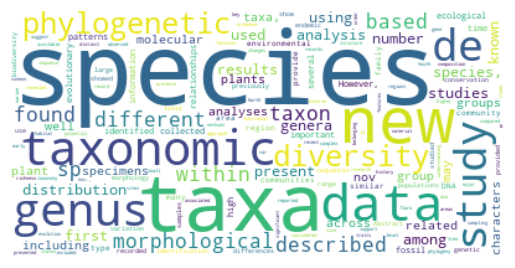

In [11]:
wordcloud_abstracts_json(taxon_publications, "taxon")

### 1.2. Start from journals

In [59]:
eujot_df = request_pubs_openalex("host_venue.id:", "V2764351231")
eujot_df

Number of publications associated with "European journal of taxonomy": 1134


id  \
0     https://openalex.org/W2012719615   
1     https://openalex.org/W2590646912   
2     https://openalex.org/W2912928817   
3     https://openalex.org/W2943376723   
4     https://openalex.org/W3134065662   
...                                ...   
1129  https://openalex.org/W4311610317   
1130  https://openalex.org/W4312078404   
1131  https://openalex.org/W4312090916   
1132  https://openalex.org/W4312184971   
1133  https://openalex.org/W4313226329   

                                            doi  \
0           https://doi.org/10.5852/ejt.2013.45   
1          https://doi.org/10.5852/ejt.2017.283   
2          https://doi.org/10.5852/ejt.2019.492   
3          https://doi.org/10.5852/ejt.2019.522   
4     https://doi.org/10.5852/ejt.2021.736.1257   
...                                         ...   
1129  https://doi.org/10.5852/ejt.2022.852.2007   
1130  https://doi.org/10.5852/ejt.2022.852.2013   
1131  https://doi.org/10.5852/ejt.2022.852.2015   
1132  https://doi.org/10.5852/ejt.2022.852.2017   
1133  https://doi.org/10.5852/ejt.2022.853.2019   

                                                  title  \
0     A review of the tribes of Deltocephalinae (Hem...   
1                 Pitfalls in supermatrix phylogenomics   
2     A subjective global checklist of the extant no...   
3     Micro-computed tomography for natural history ...   
4     An updated classification of the jumping plant...   
...                                                 ...   
1129  A new technique and software to optimize compr...   
1130  Gigasanalis, a new genus of the tribe Achilini...   
1131  Biema Huo &amp; Zhao gen. nov., a new flower f...   
1132  Preliminary revision of the Indian cuckoo wasp...   
1133     A revision of the genus Malus Mill. (Rosaceae)   

                                           display_name  publication_year  \
0     A review of the tribes of Deltocephalinae (Hem...              2013   
1                 Pitfalls in supermatrix phylogenomics              2017   
2     A subjective global checklist of the extant no...              2019   
3     Micro-computed tomography for natural history ...              2019   
4     An updated classification of the jumping plant...              2021   
...                                                 ...               ...   
1129  A new technique and software to optimize compr...              2022   
1130  Gigasanalis, a new genus of the tribe Achilini...              2022   
1131  Biema Huo &amp; Zhao gen. nov., a new flower f...              2022   
1132  Preliminary revision of the Indian cuckoo wasp...              2022   
1133     A revision of the genus Malus Mill. (Rosaceae)              2022   

     publication_date                                                ids  \
0          2013-05-29  {'openalex': 'https://openalex.org/W2012719615...   
1          2017-02-21  {'openalex': 'https://openalex.org/W2590646912...   
2          2019-01-25  {'openalex': 'https://openalex.org/W2912928817...   
3          2019-04-30  {'openalex': 'https://openalex.org/W2943376723...   
4          2021-03-05  {'openalex': 'https://openalex.org/W3134065662...   
...               ...                                                ...   
1129       2022-12-15  {'openalex': 'https://openalex.org/W4311610317...   
1130       2022-12-20  {'openalex': 'https://openalex.org/W4312078404...   
1131       2022-12-21  {'openalex': 'https://openalex.org/W4312090916...   
1132       2022-12-22  {'openalex': 'https://openalex.org/W4312184971...   
1133       2022-12-28  {'openalex': 'https://openalex.org/W4313226329...   

                                             host_venue             type  \
0     {'id': 'https://openalex.org/V2764351231', 'is...  journal-article   
1     {'id': 'https://openalex.org/V2764351231', 'is...  journal-article   
2     {'id': 'https://openalex.org/V2764351231', 'is...  journal-article   
3     {'id': 'https://openalex.org/V2764351231', 'is...  journal-ar

In [18]:
# save data to break up notebook
eujot_df.to_csv("./data/europeanjournaloftaxonomy.csv")
eujot_df.to_pickle("./data/europeanjournaloftaxonomy.pkl")

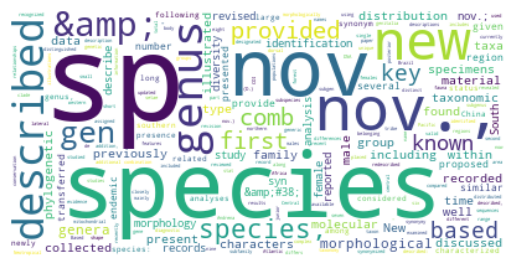

In [15]:
wordcloud_abstracts_json(eujot_df, "eujot")

### 1.3. Query all scientific journals on taxonomy
From Wikidata, SPARQL query

Selected on "scientific journal" as instance of and "taxonomy" as main subject

In [123]:
# code almost verbatim from wikidata query builder and query service
query = """SELECT DISTINCT ?item ?itemLabel ?issn ?issn_l WHERE {
    ?item wdt:P236 ?issn.
    ?item wdt:P7363 ?issn_l.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P31 ?statement0.
      ?statement0 (ps:P31/(wdt:P279*)) wd:Q5633421.
      ?item p:P921 ?statement1.
      ?statement1 (ps:P921/(wdt:P279*)) wd:Q8269924.
    }
    LIMIT 100
  }
}"""

results_df = get_sparql_results(query)
results_df

item  \
0   {'type': 'uri', 'value': 'http://www.wikidata....   
1   {'type': 'uri', 'value': 'http://www.wikidata....   
2   {'type': 'uri', 'value': 'http://www.wikidata....   
3   {'type': 'uri', 'value': 'http://www.wikidata....   
4   {'type': 'uri', 'value': 'http://www.wikidata....   
5   {'type': 'uri', 'value': 'http://www.wikidata....   
6   {'type': 'uri', 'value': 'http://www.wikidata....   
7   {'type': 'uri', 'value': 'http://www.wikidata....   
8   {'type': 'uri', 'value': 'http://www.wikidata....   
9   {'type': 'uri', 'value': 'http://www.wikidata....   
10  {'type': 'uri', 'value': 'http://www.wikidata....   
11  {'type': 'uri', 'value': 'http://www.wikidata....   
12  {'type': 'uri', 'value': 'http://www.wikidata....   
13  {'type': 'uri', 'value': 'http://www.wikidata....   

                                       issn_l  \
0   {'type': 'literal', 'value': '0132-8069'}   
1   {'type': 'literal', 'value': '1175-5326'}   
2   {'type': 'literal', 'value': '1175-5326'}   
3   {'type': 'literal', 'value': '0004-8038'}   
4   {'type': 'literal', 'value': '0004-8038'}   
5   {'type': 'literal', 'value': '1346-7565'}   
6   {'type': 'literal', 'value': '1346-7565'}   
7   {'type': 'literal', 'value': '1179-3155'}   
8   {'type': 'literal', 'value': '1179-3155'}   
9   {'type': 'literal', 'value': '2703-3082'}   
10  {'type': 'literal', 'value': '2703-3082'}   
11  {'type': 'literal', 'value': '2118-9773'}   
12  {'type': 'literal', 'value': '1313-2970'}   
13  {'type': 'literal', 'value': '1313-2970'}   

                                         issn  \
0   {'type': 'literal', 'value': '0132-8069'}   
1   {'type': 'literal', 'value': '1175-5334'}   
2   {'type': 'literal', 'value': '1175-5326'}   
3   {'type': 'literal', 'value': '0004-8038'}   
4   {'type': 'literal', 'value': '1938-4254'}   
5   {'type': 'literal', 'value': '1346-7565'}   
6   {'type': 'literal', 'value': '2189-7042'}   
7   {'type': 'literal', 'value': '1179-3155'}   
8   {'type': 'literal', 'value': '1179-3163'}   
9   {'type': 'literal', 'value': '2703-3082'}   
10  {'type': 'literal', 'value': '2703-3090'}   
11  {'type': 'literal', 'value': '2118-9773'}   
12  {'type': 'literal', 'value': '1313-2970'}   
13  {'type': 'literal', 'value': '1313-2989'}   

                                    itemLabel  
0   {'type': 'literal', 'value': 'Q21385717'}  
1     {'type': 'literal', 'value': 'Q220370'}  
2     {'type': 'literal', 'value': 'Q220370'}  
3    {'type': 'literal', 'value': 'Q2300649'}  
4    {'type': 'literal', 'value': 'Q2300649'}  
5    {'type': 'literal', 'value': 'Q5656888'}  
6    {'type': 'literal', 'value': 'Q5656888'}  
7    {'type': 'literal', 'value': 'Q4807825'}  
8    {'type': 'literal', 'value': 'Q4807825'}  
9   {'type': 'literal', 'value': 'Q96729295'}  
10  {'type': 'literal', 'value': 'Q96729295'}  
11  {'type': 'literal', 'value': 'Q21386186'}  
12    {'type': 'literal', 'value': 'Q219980'}  
13    {'type': 'literal', 'value': 'Q219980'}

In [118]:
all_journals = search_issn_from_sparql(results_df)

{'1313-2970', '2118-9773', '2703-3082', '0132-8069', '1175-5326', '1179-3155', '0004-8038'}
1313-2970 aka ZooKeys: done
2118-9773 aka European journal of taxonomy: done
2703-3082 aka Megataxa: done
0132-8069 aka Russian entomological journal: done
1175-5326 aka Zootaxa: done
1179-3155 aka Phytotaxa: done
0004-8038 aka The Auk: done


In [93]:
# save data to break up notebook
all_journals.to_csv("./data/alltaxonomyjournals.csv")
all_journals.to_pickle("./data/alltaxonomyjournals.pkl")

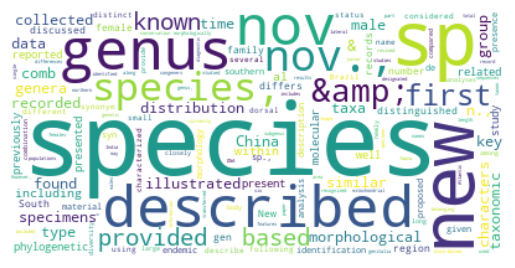

In [100]:
wordcloud_abstracts_json(all_journals, "alltaxonomyjournals")

### 1.4. Expanding which journals are selected

To-do: 
- use "field of work" instead of "main subject",
- "acadamic journal" as well as "scientific journal"

In [125]:
# "academic journal" OR "scientific journal" 
# taxonomy as "field of work" OR "main subject"

query = """SELECT DISTINCT ?item ?itemLabel ?issn ?issn_l WHERE {
    ?item wdt:P236 ?issn.
    ?item wdt:P7363 ?issn_l.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      {
        ?item p:P31 ?statement0.
        ?statement0 (ps:P31/(wdt:P279*)) wd:Q5633421.
      }
      UNION
      {
        ?item p:P31 ?statement1.
        ?statement1 (ps:P31/(wdt:P279*)) wd:Q737498.
      }
      {
        ?item p:P921 ?statement2.
        ?statement2 (ps:P921/(wdt:P279*)) wd:Q8269924.
      }
      UNION
      {
        ?item p:P101 ?statement3.
        ?statement3 (ps:P101/(wdt:P279*)) wd:Q8269924.
      }
    }
    LIMIT 100
  }
}"""

results_df = get_sparql_results(query)
results_df

item  \
0   {'type': 'uri', 'value': 'http://www.wikidata....   
1   {'type': 'uri', 'value': 'http://www.wikidata....   
2   {'type': 'uri', 'value': 'http://www.wikidata....   
3   {'type': 'uri', 'value': 'http://www.wikidata....   
4   {'type': 'uri', 'value': 'http://www.wikidata....   
5   {'type': 'uri', 'value': 'http://www.wikidata....   
6   {'type': 'uri', 'value': 'http://www.wikidata....   
7   {'type': 'uri', 'value': 'http://www.wikidata....   
8   {'type': 'uri', 'value': 'http://www.wikidata....   
9   {'type': 'uri', 'value': 'http://www.wikidata....   
10  {'type': 'uri', 'value': 'http://www.wikidata....   
11  {'type': 'uri', 'value': 'http://www.wikidata....   
12  {'type': 'uri', 'value': 'http://www.wikidata....   
13  {'type': 'uri', 'value': 'http://www.wikidata....   
14  {'type': 'uri', 'value': 'http://www.wikidata....   
15  {'type': 'uri', 'value': 'http://www.wikidata....   
16  {'type': 'uri', 'value': 'http://www.wikidata....   
17  {'type': 'uri', 'value': 'http://www.wikidata....   

                                       issn_l  \
0   {'type': 'literal', 'value': '0132-8069'}   
1   {'type': 'literal', 'value': '1175-5326'}   
2   {'type': 'literal', 'value': '1175-5326'}   
3   {'type': 'literal', 'value': '0085-4417'}   
4   {'type': 'literal', 'value': '0085-4417'}   
5   {'type': 'literal', 'value': '0004-8038'}   
6   {'type': 'literal', 'value': '0004-8038'}   
7   {'type': 'literal', 'value': '1346-7565'}   
8   {'type': 'literal', 'value': '1346-7565'}   
9   {'type': 'literal', 'value': '1179-3155'}   
10  {'type': 'literal', 'value': '1179-3155'}   
11  {'type': 'literal', 'value': '2703-3082'}   
12  {'type': 'literal', 'value': '2703-3082'}   
13  {'type': 'literal', 'value': '2118-9773'}   
14  {'type': 'literal', 'value': '0077-1813'}   
15  {'type': 'literal', 'value': '0077-1813'}   
16  {'type': 'literal', 'value': '1313-2970'}   
17  {'type': 'literal', 'value': '1313-2970'}   

                                         issn  \
0   {'type': 'literal', 'value': '0132-8069'}   
1   {'type': 'literal', 'value': '1175-5334'}   
2   {'type': 'literal', 'value': '1175-5326'}   
3   {'type': 'literal', 'value': '0085-4417'}   
4   {'type': 'literal', 'value': '2200-2790'}   
5   {'type': 'literal', 'value': '0004-8038'}   
6   {'type': 'literal', 'value': '1938-4254'}   
7   {'type': 'literal', 'value': '1346-7565'}   
8   {'type': 'literal', 'value': '2189-7042'}   
9   {'type': 'literal', 'value': '1179-3155'}   
10  {'type': 'literal', 'value': '1179-3163'}   
11  {'type': 'literal', 'value': '2703-3082'}   
12  {'type': 'literal', 'value': '2703-3090'}   
13  {'type': 'literal', 'value': '2118-9773'}   
14  {'type': 'literal', 'value': '0077-1813'}   
15  {'type': 'literal', 'value': '2204-2032'}   
16  {'type': 'literal', 'value': '1313-2970'}   
17  {'type': 'literal', 'value': '1313-2989'}   

                                    itemLabel  
0   {'type': 'literal', 'value': 'Q21385717'}  
1     {'type': 'literal', 'value': 'Q220370'}  
2     {'type': 'literal', 'value': 'Q220370'}  
3    {'type': 'literal', 'value': 'Q2005798'}  
4    {'type': 'literal', 'value': 'Q2005798'}  
5    {'type': 'literal', 'value': 'Q2300649'}  
6    {'type': 'literal', 'value': 'Q2300649'}  
7    {'type': 'literal', 'value': 'Q5656888'}  
8    {'type': 'literal', 'value': 'Q5656888'}  
9    {'type': 'literal', 'value': 'Q4807825'}  
10   {'type': 'literal', 'value': 'Q4807825'}  
11  {'type': 'literal', 'value': 'Q96729295'}  
12  {'type': 'literal', 'value': 'Q96729295'}  
13  {'type': 'literal', 'value': 'Q21386186'}  
14  {'type': 'literal', 'value': 'Q11693922'}  
15  {'type': 'literal', 'value': 'Q11693922'}  
16    {'type': 'literal', 'value': 'Q219980'}  
17    {'type': 'literal', 'value': 'Q219980'}

In [103]:
all_journals = search_issn_from_sparql(results_df)

{'0085-4417', '1313-2970', '2118-9773', '2703-3082', '0132-8069', '1175-5326', '1179-3155', '0004-8038'}
0085-4417 aka Nuytsia: done
1313-2970 aka ZooKeys: done
2118-9773 aka European journal of taxonomy: done
2703-3082 aka Megataxa: done
0132-8069 aka Russian entomological journal: done
1175-5326 aka Zootaxa: done
1179-3155 aka Phytotaxa: done
0004-8038 aka The Auk: done


index                                id  \
0          0  https://openalex.org/W2270295828   
1          1  https://openalex.org/W2530361294   
2          2  https://openalex.org/W2608730382   
3          3  https://openalex.org/W3095827733   
4          4  https://openalex.org/W3212054237   
...      ...                               ...   
44292   1001  https://openalex.org/W4307325090   
44293   1002  https://openalex.org/W4307325092   
44294   1003  https://openalex.org/W4308204288   
44295   1004  https://openalex.org/W4312081928   
44296   1005  https://openalex.org/W4312207791   

                                               doi  \
0                                             None   
1                                             None   
2                                             None   
3                                             None   
4                                             None   
...                                            ...   
44292  https://doi.org/10.1093/ornithology/ukac054   
44293  https://doi.org/10.1093/ornithology/ukac053   
44294  https://doi.org/10.1093/ornithology/ukac055   
44295  https://doi.org/10.1093/ornithology/ukac060   
44296  https://doi.org/10.1093/ornithology/ukac056   

                                                   title  \
0      A baker's dozen of new wattles highlights sign...   
1      A revision of species from the tribe lasiopeta...   
2      Acacia mackenziei, a new species of Acacia sec...   
3      Nomenclatural changes in Chenopodium (incl. Rh...   
4      A revision of the Lasiopetalum floribundum gro...   
...                                                  ...   
44292  A rallid ballad: Communal signaling is correla...   
44293  Professional ethics survey identifies strength...   
44294  Asymmetric song recognition does not influence...   
44295  Gradual transitions in genetics and songs betw...   
44296  Evidence of differing staging strategies betwe...   

                                            display_name  publication_year  \
0      A baker's dozen of new wattles highlights sign...              2013   
1      A revision of species from the tribe lasiopeta...              2015   
2      Acacia mackenziei, a new species of Acacia sec...              2014   
3      Nomenclatural changes in Chenopodium (incl. Rh...              2017   
4      A revision of the Lasiopetalum floribundum gro...              2017   
...                                                  ...               ...   
44292  A rallid ballad: Communal signaling is correla...              2022   
44293  Professional ethics survey identifies strength...              2022   
44294  Asymmetric song recognition does not influence...              2022   
44295  Gradual transitions in genetics and songs betw...              2022   
44296  Evidence of differing staging strategies betwe...              2022   

      publication_date                                                ids  \
0           2013-01-01  {'openalex': 'https://openalex.org/W2270295828...   
1           2015-01-01  {'openalex': 'https://openalex.org/W2530361294...   
2           2014-01-01  {'openalex': 'https://openalex.org/W2608730382...   
3           2017-01-01  {'openalex': 'https://openalex.org/W3095827733...   
4           2017-01-01  {'openalex': 'https://openalex.org/W3212054237...   
...                ...                                                ...   
44292       2022-10-26  {'openalex': 'https://openalex.org/W4307325090...   
44293       2022-10-26  {'openalex': 'https://openalex.org/W4307325092...   
44294       2022-11-04  {'openalex': 'https://openalex.org/W4308204288...   
44295       2022-12-20  {'openalex': 'https://openalex.org/W4312081928...   
44296       2022-12-06  {'openalex': 'https://openalex.org/W4312207791...   

                                              host_venue             type  \
0      {'id': 'https://openalex.org/V103214341', 'iss...  journal-article   
1      {'id': 'https

In [104]:
# save data to break up notebook
all_journals.to_csv("./data/more_alltaxonomyjournals.csv")
all_journals.to_pickle("./data/more_alltaxonomyjournals.pkl")

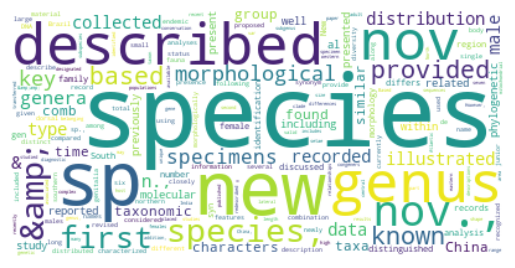

In [106]:
wordcloud_abstracts_json(all_journals, "all_alltaxonomyjournals")

To-do:
- include "botany" as main subject, 
- other main subjects such as entymology, mycology and zoology

Tried botany, mycology, and zoology together, but there are too many hits (many of them unrelated to taxonomy sensu strictu). Botany on its own includes many agricultural journals which distract from our goal.

To-do:
- include "biological classification" as a main subject (adds some results!)
- include other similar categories (plant-specific or not): "systematics", "plant taxonomy", "animal taxonomy" (adds many results!)
- (classification of birds)
- query for subclasses of taxonomy: Q14458981, Q1953620, Q2525110 (taxonomy of specific groups)
- many subclasses of biological classification: query with main subject/field of study = subclass of bio. class.

blind spot: mycological taxonomy, e.g. the journal Mycotaxon is specific to this subject but only has "mycology" as field of study/main subject and just "journal" as description, rendering it hard to distinguish from other more general mycological journals.

(other route: something like "type species" or "species")

In [34]:
query = build_query_subjects(["Q8269924", # taxonomy
                              "Q11398", # biological classification
                              "Q1138178", # plant taxonomy
                              "Q1469725", # animal taxonomy
                              "Q3516404"]) # systematics

results_df = get_sparql_results(query)
results_df

item  \
0   {'type': 'uri', 'value': 'http://www.wikidata....   
1   {'type': 'uri', 'value': 'http://www.wikidata....   
2   {'type': 'uri', 'value': 'http://www.wikidata....   
3   {'type': 'uri', 'value': 'http://www.wikidata....   
4   {'type': 'uri', 'value': 'http://www.wikidata....   
5   {'type': 'uri', 'value': 'http://www.wikidata....   
6   {'type': 'uri', 'value': 'http://www.wikidata....   
7   {'type': 'uri', 'value': 'http://www.wikidata....   
8   {'type': 'uri', 'value': 'http://www.wikidata....   
9   {'type': 'uri', 'value': 'http://www.wikidata....   
10  {'type': 'uri', 'value': 'http://www.wikidata....   
11  {'type': 'uri', 'value': 'http://www.wikidata....   
12  {'type': 'uri', 'value': 'http://www.wikidata....   
13  {'type': 'uri', 'value': 'http://www.wikidata....   
14  {'type': 'uri', 'value': 'http://www.wikidata....   
15  {'type': 'uri', 'value': 'http://www.wikidata....   
16  {'type': 'uri', 'value': 'http://www.wikidata....   
17  {'type': 'uri', 'value': 'http://www.wikidata....   
18  {'type': 'uri', 'value': 'http://www.wikidata....   
19  {'type': 'uri', 'value': 'http://www.wikidata....   
20  {'type': 'uri', 'value': 'http://www.wikidata....   
21  {'type': 'uri', 'value': 'http://www.wikidata....   
22  {'type': 'uri', 'value': 'http://www.wikidata....   
23  {'type': 'uri', 'value': 'http://www.wikidata....   
24  {'type': 'uri', 'value': 'http://www.wikidata....   
25  {'type': 'uri', 'value': 'http://www.wikidata....   
26  {'type': 'uri', 'value': 'http://www.wikidata....   
27  {'type': 'uri', 'value': 'http://www.wikidata....   
28  {'type': 'uri', 'value': 'http://www.wikidata....   
29  {'type': 'uri', 'value': 'http://www.wikidata....   
30  {'type': 'uri', 'value': 'http://www.wikidata....   
31  {'type': 'uri', 'value': 'http://www.wikidata....   
32  {'type': 'uri', 'value': 'http://www.wikidata....   
33  {'type': 'uri', 'value': 'http://www.wikidata....   
34  {'type': 'uri', 'value': 'http://www.wikidata....   
35  {'type': 'uri', 'value': 'http://www.wikidata....   
36  {'type': 'uri', 'value': 'http://www.wikidata....   
37  {'type': 'uri', 'value': 'http://www.wikidata....   
38  {'type': 'uri', 'value': 'http://www.wikidata....   
39  {'type': 'uri', 'value': 'http://www.wikidata....   
40  {'type': 'uri', 'value': 'http://www.wikidata....   
41  {'type': 'uri', 'value': 'http://www.wikidata....   
42  {'type': 'uri', 'value': 'http://www.wikidata....   
43  {'type': 'uri', 'value': 'http://www.wikidata....   
44  {'type': 'uri', 'value': 'http://www.wikidata....   
45  {'type': 'uri', 'value': 'http://www.wikidata....   
46  {'type': 'uri', 'value': 'http://www.wikidata....   
47  {'type': 'uri', 'value': 'http://www.wikidata....   
48  {'type': 'uri', 'value': 'http://www.wikidata....   
49  {'type': 'uri', 'value': 'http://www.wikidata....   

                                       issn_l  \
0   {'type': 'literal', 'value': '0376-4443'}   
1   {'type': 'literal', 'value': '1063-5157'}   
2   {'type': 'literal', 'value': '1063-5157'}   
3   {'type': 'literal', 'value': '1225-8318'}   
4   {'type': 'literal', 'value': '1225-8318'}   
5   {'type': 'literal', 'value': '1394-5130'}   
6   {'type': 'literal', 'value': '0132-8069'}   
7   {'type': 'literal', 'value': '1175-5326'}   
8   {'type': 'literal', 'value': '1314-2488'}   
9   {'type': 'literal', 'value': '1314-2488'}   
10  {'type': 'literal', 'value': '0367-5041'}   
11  {'type': 'literal', 'value': '0367-5041'}   
12  {'type': 'literal', 'value': '1175-5326'}   
13  {'type': 'literal', 'value': '2234-6953'}   
14  {'type': 'literal', 'value': '2234-6953'}   
15  {'type': 'literal', 'value': '0085-4417'}   
16  {'type': 'literal', 'value': '0085-4417'}   
17  {'type': 'literal', 'value': '1435-1935'}   
18  {'type': 'literal', 'value': '1435-1935'}   
19  {'type': 'literal', 'value': '0075-5974'}   
20  {'type': 'literal', 'value': '0075-5974'}   
21  {'type': 'literal', 'value': '0004-8038'}   
22  {'type': '

In [40]:
# add biological nomenclature, zoological nomenclature, botanical nomenclature (and previous)

query = build_query_subjects(["Q8269924", # taxonomy
                              "Q11398", # biological classification
                              "Q1138178", # plant taxonomy
                              "Q1469725", # animal taxonomy
                              "Q3516404", # systematics
                              "Q522190", # biological nomenclature
                              "Q3310776", # botanical nomenclature
                              "Q3343211", # zoological nomenclature
                              "Q171184", # phylogenetics
                              "Q115135896"]) # animal phylogeny
print(query)

results_df = get_sparql_results(query)
results_df

SELECT DISTINCT ?item ?itemLabel ?issn ?issn_l WHERE {
    ?item wdt:P236 ?issn.
    ?item wdt:P7363 ?issn_l.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      {
        ?item p:P31 ?statement0.
        ?statement0 (ps:P31/(wdt:P279*)) wd:Q5633421.
      }
      UNION
      {
        ?item p:P31 ?statement1.
        ?statement1 (ps:P31/(wdt:P279*)) wd:Q737498.
      }
      {
        ?item p:P921 ?statement2.
        ?statement2 (ps:P921/(wdt:P279*)) wd:Q8269924.
      }
      UNION
      {
        ?item p:P101 ?statement3.
        ?statement3 (ps:P101/(wdt:P279*)) wd:Q8269924.
      }
      UNION
      {
        ?item p:P921 ?statement4.
        ?statement4 (ps:P921/(wdt:P279*)) wd:Q11398.
      }
      UNION
      {
        ?item p:P101 ?statement5.
        ?statement5 (ps:P101/(wdt:P279*)) wd:Q11398.
      }
      UNION
      {
        ?item p:P921 ?statement6.
        ?statement6 (ps:P921/(wdt:P279*)) wd:Q1

EndPointInternalError: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'SPARQL-QUERY: queryStr=SELECT DISTINCT ?item ?itemLabel ?issn ?issn_l WHERE {\n    ?item wdt:P236 ?issn.\n    ?item wdt:P7363 ?issn_l.\n  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }\n  {\n    SELECT DISTINCT ?item WHERE {\n      {\n        ?item p:P31 ?statement0.\n        ?statement0 (ps:P31/(wdt:P279*)) wd:Q5633421.\n      }\n      UNION\n      {\n        ?item p:P31 ?statement1.\n        ?statement1 (ps:P31/(wdt:P279*)) wd:Q737498.\n      }\n      {\n        ?item p:P921 ?statement2.\n        ?statement2 (ps:P921/(wdt:P279*)) wd:Q8269924.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement3.\n        ?statement3 (ps:P101/(wdt:P279*)) wd:Q8269924.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement4.\n        ?statement4 (ps:P921/(wdt:P279*)) wd:Q11398.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement5.\n        ?statement5 (ps:P101/(wdt:P279*)) wd:Q11398.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement6.\n        ?statement6 (ps:P921/(wdt:P279*)) wd:Q1138178.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement7.\n        ?statement7 (ps:P101/(wdt:P279*)) wd:Q1138178.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement8.\n        ?statement8 (ps:P921/(wdt:P279*)) wd:Q1469725.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement9.\n        ?statement9 (ps:P101/(wdt:P279*)) wd:Q1469725.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement10.\n        ?statement10 (ps:P921/(wdt:P279*)) wd:Q3516404.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement11.\n        ?statement11 (ps:P101/(wdt:P279*)) wd:Q3516404.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement12.\n        ?statement12 (ps:P921/(wdt:P279*)) wd:Q522190.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement13.\n        ?statement13 (ps:P101/(wdt:P279*)) wd:Q522190.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement14.\n        ?statement14 (ps:P921/(wdt:P279*)) wd:Q3310776.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement15.\n        ?statement15 (ps:P101/(wdt:P279*)) wd:Q3310776.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement16.\n        ?statement16 (ps:P921/(wdt:P279*)) wd:Q3343211.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement17.\n        ?statement17 (ps:P101/(wdt:P279*)) wd:Q3343211.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement18.\n        ?statement18 (ps:P921/(wdt:P279*)) wd:Q171184.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement19.\n        ?statement19 (ps:P101/(wdt:P279*)) wd:Q171184.\n      }\n      UNION\n      {\n        ?item p:P921 ?statement20.\n        ?statement20 (ps:P921/(wdt:P279*)) wd:Q115135896.\n      }\n      UNION\n      {\n        ?item p:P101 ?statement21.\n        ?statement21 (ps:P101/(wdt:P279*)) wd:Q115135896.\n      }\n    }\n  }\n}\njava.util.concurrent.TimeoutException\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:205)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doGet(QueryServlet.java:290)\n\tat com.bigdata.rdf.sail.webapp.RESTServlet.doGet(RESTServlet.java:240)\n\tat com.bigdata.rdf.sail.webapp.MultiTenancyServlet.doGet(MultiTenancyServlet.java:273)\n\tat javax.servlet.http.HttpServlet.service(HttpServlet.java:687)\n\tat javax.servlet.http.HttpServlet.service(HttpServlet.java:790)\n\tat org.eclipse.jetty.servlet.ServletHolder.handle(ServletHolder.java:865)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1655)\n\tat org.wikidata.query.rdf.blazegraph.throttling.ThrottlingFilter.doFilter(ThrottlingFilter.java:320)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.throttling.SystemOverloadFilter.doFilter(SystemOverloadFilter.java:82)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat ch.qos.logback.classic.helpers.MDCInsertingServletFilter.doFilter(MDCInsertingServletFilter.java:49)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.QueryEventSenderFilter.doFilter(QueryEventSenderFilter.java:116)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.ClientIPFilter.doFilter(ClientIPFilter.java:43)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.JWTIdentityFilter.doFilter(JWTIdentityFilter.java:66)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.RealAgentFilter.doFilter(RealAgentFilter.java:33)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1642)\n\tat org.wikidata.query.rdf.blazegraph.filters.RequestConcurrencyFilter.doFilter(RequestConcurrencyFilter.java:50)\n\tat org.eclipse.jetty.servlet.ServletHandler$CachedChain.doFilter(ServletHandler.java:1634)\n\tat org.eclipse.jetty.servlet.ServletHandler.doHandle(ServletHandler.java:533)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:146)\n\tat org.eclipse.jetty.security.SecurityHandler.handle(SecurityHandler.java:548)\n\tat org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:257)\n\tat org.eclipse.jetty.server.session.SessionHandler.doHandle(SessionHandler.java:1595)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextHandle(ScopedHandler.java:255)\n\tat org.eclipse.jetty.server.handler.ContextHandler.doHandle(ContextHandler.java:1340)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:203)\n\tat org.eclipse.jetty.servlet.ServletHandler.doScope(ServletHandler.java:473)\n\tat org.eclipse.jetty.server.session.SessionHandler.doScope(SessionHandler.java:1564)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.nextScope(ScopedHandler.java:201)\n\tat org.eclipse.jetty.server.handler.ContextHandler.doScope(ContextHandler.java:1242)\n\tat org.eclipse.jetty.server.handler.ScopedHandler.handle(ScopedHandler.java:144)\n\tat org.eclipse.jetty.server.handler.ContextHandlerCollection.handle(ContextHandlerCollection.java:220)\n\tat org.eclipse.jetty.server.handler.HandlerCollection.handle(HandlerCollection.java:126)\n\tat org.eclipse.jetty.server.handler.HandlerWrapper.handle(HandlerWrapper.java:132)\n\tat org.eclipse.jetty.server.Server.handle(Server.java:503)\n\tat org.eclipse.jetty.server.HttpChannel.handle(HttpChannel.java:364)\n\tat org.eclipse.jetty.server.HttpConnection.onFillable(HttpConnection.java:260)\n\tat org.eclipse.jetty.io.AbstractConnection$ReadCallback.succeeded(AbstractConnection.java:305)\n\tat org.eclipse.jetty.io.FillInterest.fillable(FillInterest.java:103)\n\tat org.eclipse.jetty.io.ChannelEndPoint$2.run(ChannelEndPoint.java:118)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.runTask(EatWhatYouKill.java:333)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:310)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:168)\n\tat org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:126)\n\tat org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:366)\n\tat org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:765)\n\tat org.eclipse.jetty.util.thread.QueuedThreadPool$2.run(QueuedThreadPool.java:683)\n\tat java.lang.Thread.run(Thread.java:750)\n'

In [46]:
# add biological nomenclature, zoological nomenclature, botanical nomenclature (and previous)
# add phylogenetics, animal phylogenetics

query = build_query_subjects(["Q8269924", # taxonomy
                              "Q11398", # biological classification
                              "Q1138178", # plant taxonomy
                              "Q1469725", # animal taxonomy
                              "Q3516404", # systematics
                              "Q522190", # biological nomenclature
                              "Q3310776", # botanical nomenclature
                              "Q3343211"]) # zoological nomenclature
query2 = build_query_subjects(["Q171184", # phylogenetics
                               "Q115135896"]) # animal phylogeny

results_df = get_sparql_results(query)
results_df2 = get_sparql_results(query2)

results_df = pd.concat([results_df, results_df2], ignore_index=True)
results_df

item  \
0   {'type': 'uri', 'value': 'http://www.wikidata....   
1   {'type': 'uri', 'value': 'http://www.wikidata....   
2   {'type': 'uri', 'value': 'http://www.wikidata....   
3   {'type': 'uri', 'value': 'http://www.wikidata....   
4   {'type': 'uri', 'value': 'http://www.wikidata....   
5   {'type': 'uri', 'value': 'http://www.wikidata....   
6   {'type': 'uri', 'value': 'http://www.wikidata....   
7   {'type': 'uri', 'value': 'http://www.wikidata....   
8   {'type': 'uri', 'value': 'http://www.wikidata....   
9   {'type': 'uri', 'value': 'http://www.wikidata....   
10  {'type': 'uri', 'value': 'http://www.wikidata....   
11  {'type': 'uri', 'value': 'http://www.wikidata....   
12  {'type': 'uri', 'value': 'http://www.wikidata....   
13  {'type': 'uri', 'value': 'http://www.wikidata....   
14  {'type': 'uri', 'value': 'http://www.wikidata....   
15  {'type': 'uri', 'value': 'http://www.wikidata....   
16  {'type': 'uri', 'value': 'http://www.wikidata....   
17  {'type': 'uri', 'value': 'http://www.wikidata....   
18  {'type': 'uri', 'value': 'http://www.wikidata....   
19  {'type': 'uri', 'value': 'http://www.wikidata....   
20  {'type': 'uri', 'value': 'http://www.wikidata....   
21  {'type': 'uri', 'value': 'http://www.wikidata....   
22  {'type': 'uri', 'value': 'http://www.wikidata....   
23  {'type': 'uri', 'value': 'http://www.wikidata....   
24  {'type': 'uri', 'value': 'http://www.wikidata....   
25  {'type': 'uri', 'value': 'http://www.wikidata....   
26  {'type': 'uri', 'value': 'http://www.wikidata....   
27  {'type': 'uri', 'value': 'http://www.wikidata....   
28  {'type': 'uri', 'value': 'http://www.wikidata....   
29  {'type': 'uri', 'value': 'http://www.wikidata....   
30  {'type': 'uri', 'value': 'http://www.wikidata....   
31  {'type': 'uri', 'value': 'http://www.wikidata....   
32  {'type': 'uri', 'value': 'http://www.wikidata....   
33  {'type': 'uri', 'value': 'http://www.wikidata....   
34  {'type': 'uri', 'value': 'http://www.wikidata....   
35  {'type': 'uri', 'value': 'http://www.wikidata....   
36  {'type': 'uri', 'value': 'http://www.wikidata....   
37  {'type': 'uri', 'value': 'http://www.wikidata....   
38  {'type': 'uri', 'value': 'http://www.wikidata....   
39  {'type': 'uri', 'value': 'http://www.wikidata....   
40  {'type': 'uri', 'value': 'http://www.wikidata....   
41  {'type': 'uri', 'value': 'http://www.wikidata....   
42  {'type': 'uri', 'value': 'http://www.wikidata....   
43  {'type': 'uri', 'value': 'http://www.wikidata....   
44  {'type': 'uri', 'value': 'http://www.wikidata....   
45  {'type': 'uri', 'value': 'http://www.wikidata....   
46  {'type': 'uri', 'value': 'http://www.wikidata....   
47  {'type': 'uri', 'value': 'http://www.wikidata....   
48  {'type': 'uri', 'value': 'http://www.wikidata....   
49  {'type': 'uri', 'value': 'http://www.wikidata....   
50  {'type': 'uri', 'value': 'http://www.wikidata....   
51  {'type': 'uri', 'value': 'http://www.wikidata....   
52  {'type': 'uri', 'value': 'http://www.wikidata....   
53  {'type': 'uri', 'value': 'http://www.wikidata....   
54  {'type': 'uri', 'value': 'http://www.wikidata....   
55  {'type': 'uri', 'value': 'http://www.wikidata....   
56  {'type': 'uri', 'value': 'http://www.wikidata....   
57  {'type': 'uri', 'value': 'http://www.wikidata....   
58  {'type': 'uri', 'value': 'http://www.wikidata....   

                                       issn_l  \
0   {'type': 'literal', 'value': '0376-4443'}   
1   {'type': 'literal', 'value': '1063-5157'}   
2   {'type': 'literal', 'value': '1063-5157'}   
3   {'type': 'literal', 'value': '1225-8318'}   
4   {'type': 'literal', 'value': '1225-8318'}   
5   {'type': 'literal', 'value': '1394-5130'}   
6   {'type': 'literal', 'value': '0132-8069'}   
7   {'type': 'literal', 'value': '1175-5326'}   
8   {'type': 'literal', 'value': '1314-2488'}   
9   {'type': 'literal', 'value': '1314-2488'}   
10  {'type': 'literal', 'value': '0367-5041'}   
11  {'type': 'literal', 'value': '0367-5

In [45]:
all_journals = search_issn_from_sparql(results_df)

{'0007-5167', '1314-2488', '2118-9773', '0075-5974', '1759-6831', '0132-8069', '1175-5326', '0085-4417', '0300-3256', '1179-3155', '0004-8038', '1522-8339', '1055-7903', '2703-3082', '1179-7649', '1435-1935', '1063-5157', '1314-2003', '2234-6953', '1313-2970', '1030-1887', '0307-6970', '2399-3421', '0511-9618', '1225-8318', '0367-5041'}
0007-5167 aka The Bulletin of zoological nomenclature: done
1314-2488 aka NeoBiota: done
2118-9773 aka European journal of taxonomy: done
0075-5974 aka Kew Bulletin: done
1759-6831 aka Journal of Systematics and Evolution: done
0132-8069 aka Russian entomological journal: done
1175-5326 aka Zootaxa: done
0085-4417 aka Nuytsia: done
0300-3256 aka Zoologica Scripta: done
1179-3155 aka Phytotaxa: done
0004-8038 aka The Auk: done
1522-8339 aka Native Plants Journal: done
1055-7903 aka Molecular Phylogenetics and Evolution: done
2703-3082 aka Megataxa: done
1179-7649 aka Bionomina: done
1435-1935 aka Zoosystematics and Evolution: done
1063-5157 aka Systemati

In [47]:
# save data to break up notebook
all_journals.to_csv("./data/tax_nomen_phyl_journals.csv")
all_journals.to_pickle("./data/tax_nomen_phyl_journals.pkl")